In [1]:
import os
import requests

from tqdm import tqdm
from livelossplot import PlotLosses

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiplicativeLR

from OrnsteinUhlenbeck.n_standart_ou import VasicekModel, mle_ou
from plt_utils import save_plot

In [2]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 22})
plt.rc('axes', labelsize=22)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
np.random.seed(42)

In [5]:
dt = 0.01
t = np.arange(0, 100, dt)

In [6]:
q = {"s_0": 1.0, "kappa": 20.0, "theta": 1.0, "sigma": 1.0}

In [7]:
ou = VasicekModel(**q)
x = ou.path(t)

plt.xlabel("t")
plt.ylabel("S")
plt.plot(t, x, color="black")
save_plot(plt, "vasicek_20_1")

/home/ilgizar/thesis/Thesis/plt_utils.py:15: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  frameon=None, metadata=None)


In [8]:
train_size = int(len(x) * 0.8)

#LSTM preprocess
X = [[v] for v in x]

# Vasicek preprocess
v_train, v_test = list(x[:train_size]), x[train_size:]

# Price prediction

# Naive prediction baseline

Test MSE: 0.011042


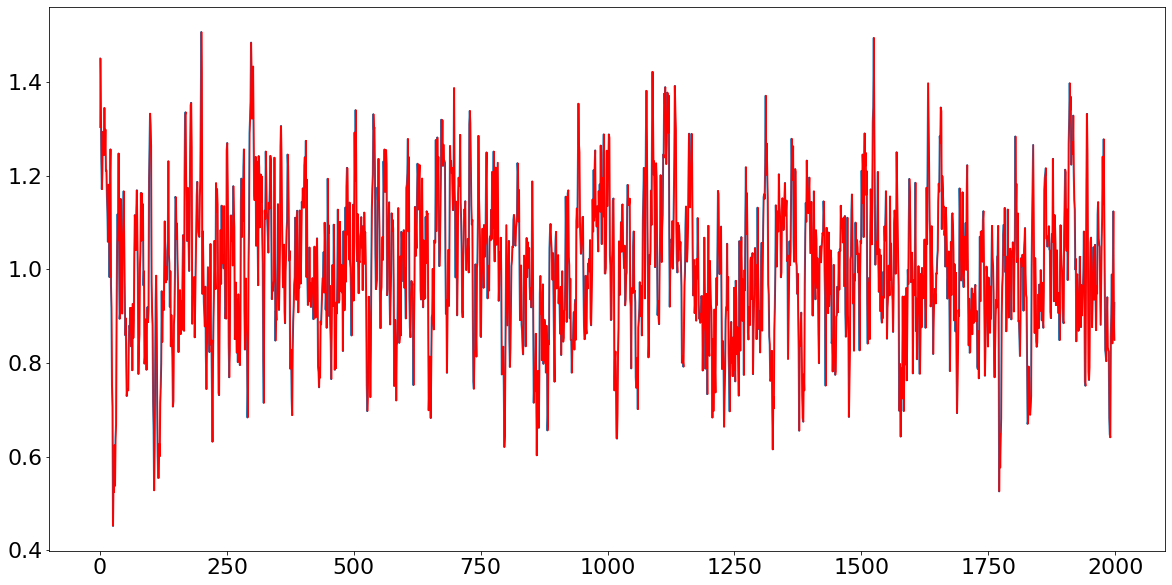

In [9]:
predictions = [v_train[-1]]
predictions.extend(v_test[:-1])
    
error = mean_squared_error(v_test, predictions)
print('Test MSE: %.6f' % error)


# plot
plt.plot(v_test)
plt.plot(predictions, color='red')
plt.show()

# Drift method

Test MSE: 0.011043


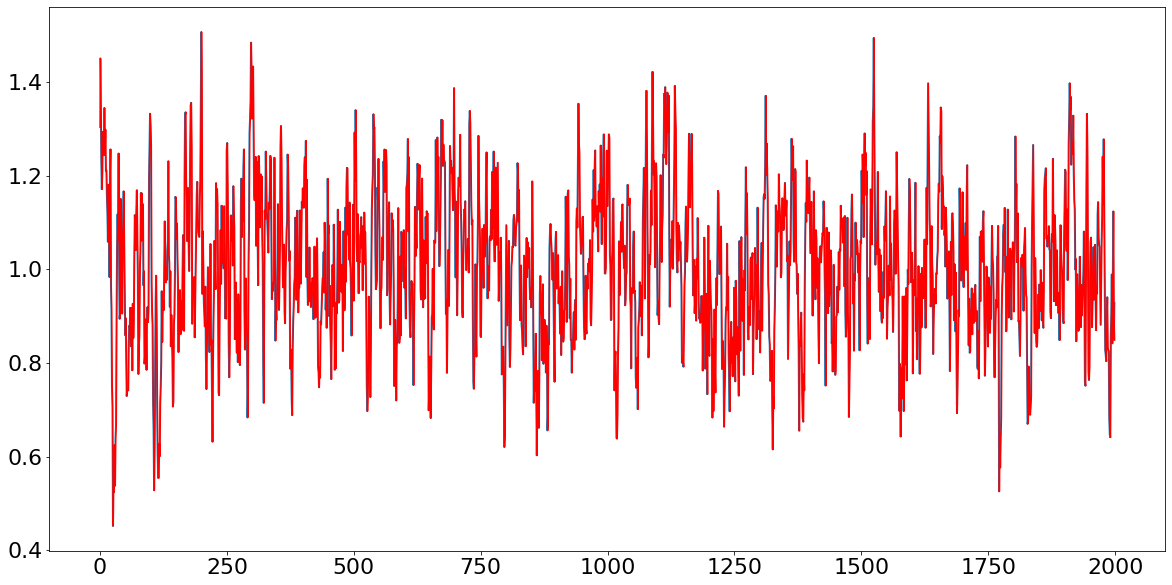

In [10]:
history_len = len(v_train)
predictions = [(history_len * v_train[-1] - v_train[0]) / (history_len - 1)]
for s_t in v_test[:-1]:
    predictions.append((history_len * s_t - v_train[0]) / (history_len - 1))
    history_len += 1
    
error = mean_squared_error(v_test, predictions)
print('Test MSE: %.6f' % error)

# plot
plt.plot(v_test)
plt.plot(predictions, color='red')
plt.show()

# Vasicek

In [11]:
result = mle_ou(t[:train_size], v_train)
kappa = result.params["kappa"].value
theta = result.params["theta"].value
sigma = result.params["sigma"].value
q_predicted = {"kappa": kappa, "theta": theta, "sigma": sigma}
print(q_predicted)

{'kappa': 23.586594913667387, 'theta': 0.9981304688989621, 'sigma': 1.1275970989402508}


In [12]:
def predict(s_t, kappa, theta, sigma):
    return s_t + kappa * (theta - s_t) * dt

Test MSE: 0.009766


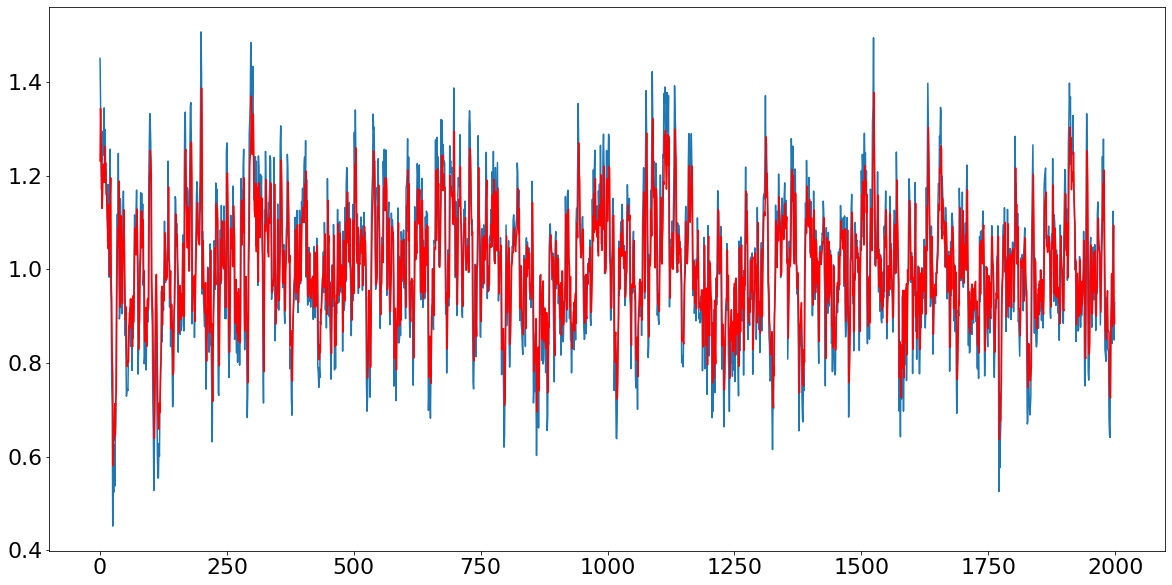

In [13]:
predictions = [predict(v_train[-1], **q_predicted)]

for s in v_test[:-1]:
    predictions.append(predict(s, **q_predicted))

error = mean_squared_error(v_test, predictions)
print('Test MSE: %.6f' % error)


# plot
plt.plot(v_test)
plt.plot(predictions, color='red')
plt.show()

# LSTM 3

In [23]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, seq_length, num_layers):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=0.2, batch_first=True)
        
        self.relu = nn.ReLU()
        
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn[-1].view(-1, self.hidden_size)
        
        out = self.relu(hn)
        out = self.linear(out)
        
        return out

In [24]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [25]:
seq_length = 100

# scaled_x, scaled_y = sliding_windows(scaler.fit_transform(X), seq_length)
lstm_x, lstm_y = sliding_windows(X, seq_length)

test_size = len(X) - train_size

trainX = torch.Tensor(np.array(lstm_x[:-test_size]))
trainY = torch.Tensor(np.array(lstm_y[:-test_size]))

testX = torch.Tensor(np.array(lstm_x[-test_size:]))
testY = torch.Tensor(np.array(lstm_y[-test_size:]))

In [26]:
dataloaderX = DataLoader(trainX, batch_size=20000, shuffle=False)
dataloaderY = DataLoader(trainY, batch_size=20000, shuffle=False)
test_dataloaderX = DataLoader(testX, batch_size=20000, shuffle=False)
test_dataloaderY = DataLoader(testY, batch_size=20000, shuffle=False)

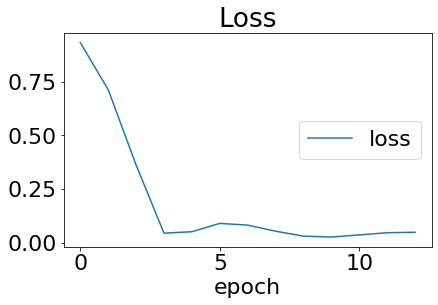

Loss
	loss             	 (min:    0.028, max:    0.931, cur:    0.050)


KeyboardInterrupt: 

In [27]:
num_epochs = 2500
learning_rate = 0.01

input_size = 1
num_layers = 3
hidden_size = 50
num_classes = 1

lstm = LSTM(input_size, hidden_size, seq_length, num_layers).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

liveloss = PlotLosses()

# Train the model
for epoch in range(num_epochs):
    logs = {}
    for batch_ind, (x_batch, y_batch) in enumerate(zip(dataloaderX, dataloaderY)):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = lstm(x_batch)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    logs['loss'] = loss.item()
    liveloss.update(logs)
    liveloss.send()
    

print(f"Epoch: {epoch}, Batch: {batch_ind} loss: {loss.item()}")

In [ ]:
lstm.eval()

testX = testX.to(device)

error = 0
predictions = []
for batch_ind, (x_batch, y_batch) in enumerate(zip(test_dataloaderX, test_dataloaderY)):
    x_batch = x_batch.to(device)

    outputs = lstm(x_batch).cpu().detach().numpy()
    
    predictions.extend(outputs)
    
error = mean_squared_error(v_test, predictions)
    
print('Test MSE: %.6f' % error)

plt.plot(testY)
plt.plot(predictions, color='red')
plt.suptitle('Time-Series Prediction')
plt.show()

# LSTM 5

In [13]:
num_epochs = 2500
learning_rate = 0.01

input_size = 1
num_layers = 5
hidden_size = 50
num_classes = 1

lstm = LSTM(input_size, hidden_size, seq_length, num_layers).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for batch_ind, (x_batch, y_batch) in enumerate(zip(dataloaderX, dataloaderY)):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = lstm(x_batch)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Batch: {batch_ind} loss: {loss.item()}")

NameError: name 'LSTM' is not defined

In [14]:
lstm.eval()

testX = testX.to(device)

error = 0
predictions = []
for batch_ind, (x_batch, y_batch) in enumerate(zip(test_dataloaderX, test_dataloaderY)):
    x_batch = x_batch.to(device)

    outputs = lstm(x_batch).cpu().detach().numpy()
    
    predictions.extend(outputs)
    
error = mean_squared_error(v_test, predictions)
    
print('Test MSE: %.6f' % error)

plt.plot(testY)
plt.plot(predictions, color='red')
plt.suptitle('Time-Series Prediction')
plt.show()

NameError: name 'lstm' is not defined

In [ ]:
print(lstm)

# Label prediction

In [14]:
from sklearn.metrics import confusion_matrix

## True labels

In [15]:
true_labels = np.diff([v_train[-1]] + v_test) >= 0

# Drift method

In [16]:
history_len = len(v_train)
predictions = [(history_len * v_train[-1] - v_train[0]) / (history_len - 1)]
for s_t in v_test[:-1]:
    predictions.append((history_len * s_t - v_train[0]) / (history_len - 1))
    history_len += 1



pred_labels = np.diff([v_train[-1]] + predictions) >= 0


tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()

assert tn + fp + fn + tp == len(v_test)

print(f"Accuracy: {(tp + tn) / len(v_test)}")

Accuracy: 0.472


# Vasicek

In [17]:
predictions = [predict(v_train[-1], **q_predicted)]

for s in v_test[:-1]:
    predictions.append(predict(s, **q_predicted))

pred_labels = np.diff([v_train[-1]] + predictions) >= 0    

tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()

assert tn + fp + fn + tp == len(v_test)

print(f"Accuracy: {(tp + tn) / len(v_test)}")

Accuracy: 0.4715


# LSTM 3

In [18]:
class LSTM_classification(nn.Module):

    def __init__(self, input_size, hidden_size, seq_length, num_layers):
        super(LSTM_classification, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=0.2, batch_first=True)
        
        self.relu = nn.ReLU()
        
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn[-1].view(-1, self.hidden_size)
        
        out = self.relu(hn)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out

In [19]:
def sliding_windows_label(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append([_y[0] - _x[-1][0] >= 0])

    return np.array(x), np.array(y)

In [20]:
seq_length = 100

# scaled_x, scaled_y = sliding_windows(scaler.fit_transform(X), seq_length)
lstm_x, lstm_y = sliding_windows_label(X, seq_length)

test_size = len(X) - train_size

trainX = torch.Tensor(np.array(lstm_x[:-test_size]))
trainY = torch.Tensor(np.array(lstm_y[:-test_size]))

testX = torch.Tensor(np.array(lstm_x[-test_size:]))
testY = torch.Tensor(np.array(lstm_y[-test_size:]))

In [21]:
dataloaderX = DataLoader(trainX, batch_size=20000, shuffle=False)
dataloaderY = DataLoader(trainY, batch_size=20000, shuffle=False)
test_dataloaderX = DataLoader(testX, batch_size=20000, shuffle=False)
test_dataloaderY = DataLoader(testY, batch_size=20000, shuffle=False)

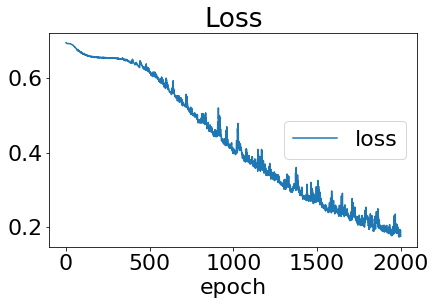

Loss
	loss             	 (min:    0.173, max:    0.695, cur:    0.175)


In [22]:
import torch.nn.functional as F

num_epochs = 2000
learning_rate = 0.001

input_size = 1
num_layers = 3
hidden_size = 100
num_classes = 1

lstm = LSTM_classification(input_size, hidden_size, seq_length, num_layers).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

liveloss = PlotLosses()

# Train the model
for epoch in range(num_epochs):
    logs = {}
    for batch_ind, (x_batch, y_batch) in enumerate(zip(dataloaderX, dataloaderY)):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = lstm(x_batch)
        optimizer.zero_grad()
        # obtain the loss function
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
    logs['loss'] = loss.item()
    liveloss.update(logs)
    liveloss.send()
# 0.5625

In [ ]:
lstm.eval()

testX = testX.to(device)

error = 0
predictions = []
for batch_ind, (x_batch, y_batch) in enumerate(zip(test_dataloaderX, test_dataloaderY)):
    x_batch = x_batch.to(device)

    outputs = lstm(x_batch).cpu().detach().numpy()
    
    predictions.extend(outputs)

predictions = np.array(predictions) >= 0.5

tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()

assert tn + fp + fn + tp == len(v_test)

print(f"Accuracy: {(tp + tn) / len(v_test)}")

# LSTM 5

In [ ]:
import torch.nn.functional as F

num_epochs = 2000
learning_rate = 0.01

input_size = 1
num_layers = 5
hidden_size = 50
num_classes = 1

lstm = LSTM_classification(input_size, hidden_size, seq_length, num_layers).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for batch_ind, (x_batch, y_batch) in enumerate(zip(dataloaderX, dataloaderY)):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = lstm(x_batch)
        optimizer.zero_grad()
        # obtain the loss function
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
    if ((epoch + 1) % 100 == 0) or epoch == 0:
        print(f"Epoch: {epoch}, Batch: {batch_ind} loss: {loss.item()}")

Epoch: 0, Batch: 0 loss: 0.6949456930160522
Epoch: 99, Batch: 0 loss: 0.6778690218925476
Epoch: 199, Batch: 0 loss: 0.649807870388031
Epoch: 299, Batch: 0 loss: 0.6121182441711426
Epoch: 399, Batch: 0 loss: 0.5236448049545288


In [ ]:
lstm.eval()

testX = testX.to(device)

error = 0
predictions = []
for batch_ind, (x_batch, y_batch) in enumerate(zip(test_dataloaderX, test_dataloaderY)):
    x_batch = x_batch.to(device)

    outputs = lstm(x_batch).cpu().detach().numpy()
    
    predictions.extend(outputs)

predictions = np.array(predictions) >= 0.5

tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()

assert tn + fp + fn + tp == len(v_test)

print(f"Accuracy: {(tp + tn) / len(v_test)}")

In [ ]:
print(lstm)

In [ ]:
print(lstm)